引力波与暗物质晕交互可视化

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import Planck18  # FlatLambdaCDM, FLRW cosmology with a cosmological constant and no curvature

In [ ]:
# set up other cosmological parameters
z_range = np.linspace(0.1,3,100)
comoving_dist = Planck18.comoving_distance(z_range)

# Distribution of dark matter halo
mass_halo = 1e12 * (1 + z_range)**2.5  # mass-z relation
density_profile = mass_halo / (4/3*np.pi*(100*3.086e21)**3)  # ~100kpc
# visualize
fig, ax = plt.subplots(figsize=(15,10))
im = ax.scatter(comoving_dist, np.zeros_like(z_range), c=density_profile, 
                cmap='viridis', s=mass_halo/1e11, alpha=0.6)
# GW path
wave_path = ax.plot(comoving_dist, 0.1*np.sin(10*comoving_dist.value), 
                    lw=2, color='cyan', label='GW path')

# 相位偏移
for z, d in zip(z_range[::10], comoving_dist[::10]):
    phase_shift = 1e-3 * (1 + z)**2  # 相位偏移模型
    ax.annotate(f'ΔΦ={phase_shift:.1e} rad', (d.value, 0), 
                rotation=45, fontsize=8)
plt.colorbar(im, label='Dark Matter Density (M⊙/pc³)')
ax.set_xlabel('Comoving Distance (Mpc)')
ax.set_title('GW Propagation through Dark Matter Halos')
plt.savefig('GW_lensing.png', dpi=300)

现有算法下双黑洞并合的SNR计算（可用于误报率计算）

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
from pycbc.noise import gaussian
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter import matched_filter
from pycbc.types import TimeSeries
from astropy.cosmology import Planck15 as cosmo

# 设置参数范围
total_mass_range = np.linspace(20, 100, 5)       # 太阳质量
q_range = np.linspace(1, 8, 5)                   # 质量比 q = m1/m2
z_range = np.linspace(0.3, 1.5, 4)               # 红移

# 设置采样率与数据长度
sample_rate = 4096
delta_t = 1.0 / sample_rate
data_len = 8      # 秒数
n_samples = int(data_len * sample_rate)

# 生成 PSD
psd = aLIGOZeroDetHighPower(n_samples//2 + 1, delta_f=1.0/data_len, low_freq_cutoff=20.0)

# 输出结果列表
results = []

for M in total_mass_range:
    for q in q_range:
        m1 = M * q / (1 + q)
        m2 = M / (1 + q)
        for z in z_range:
            # 计算红移距离
            dL = cosmo.luminosity_distance(z).to('Mpc').value

            # 生成波形（仅+极化）
            hp, hc = get_td_waveform(approximant="IMRPhenomPv2",
                                     mass1=m1, mass2=m2,
                                     distance=dL,
                                     inclination=0.0,
                                     delta_t=delta_t,
                                     f_lower=20.0)

            # 将波形裁剪为指定长度，并归一到数据长度
            hp = hp.crop(1, 1)
            hp.resize(n_samples)

            # 生成模拟噪声数据
            noise = gaussian.noise_from_psd(n_samples, delta_t, psd, seed=127)

            # 注入信号
            signal = noise.copy()
            signal.data += hp.data

            # 匹配滤波
            snr = matched_filter(hp, signal, psd=psd,
                                 low_frequency_cutoff=20.0)

            peak_snr = abs(snr).numpy().max()
            results.append((m1, m2, z, peak_snr))

            print(f"m1={m1:.1f}, m2={m2:.1f}, z={z:.2f}, SNR={peak_snr:.2f}") # 误报率的

基于Python的累积相位偏移建模

In [2]:
import numpy as np
from hmf import MassFunction
import matplotlib.pyplot as plt

# 质量：log10(M / M_sun/h)，覆盖 1e10 到 1e15
log10M = np.linspace(10, 15, 51)
mass_bins = 10**log10M
delta_log10M = log10M[1] - log10M[0]

# 红移
z_list = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

# 初始化
dn_dlogM_all = []
for z in z_list:
    mf = MassFunction(z=z, Mmin=10, Mmax=15, dlog10m=delta_log10M,
                      hmf_model="SMT",  # Sheth-Mo-Tormen
                      mdef_model='SOVirial',
                      filter_model='Gaussian')

    # dn/dlogM = dn/dlnM × ln(10)
    dn_dlogM = mf.dndlnm[:-1] * np.log(10)  # shape = (50,)
    dn_dlogM_all.append(dn_dlogM)

# 保存为 npz 文件
np.savez("ShethTormen_halo_mass_function.npz",
         z_vals=np.array(z_list),
         mass_bin_edges=mass_bins,
         dn_dlogM=np.array(dn_dlogM_all))  # shape: (Nz, Nmass_bin)

In [3]:
from IPython.display import FileLink

/home/jovyan/ShethTormen_mass_function.png

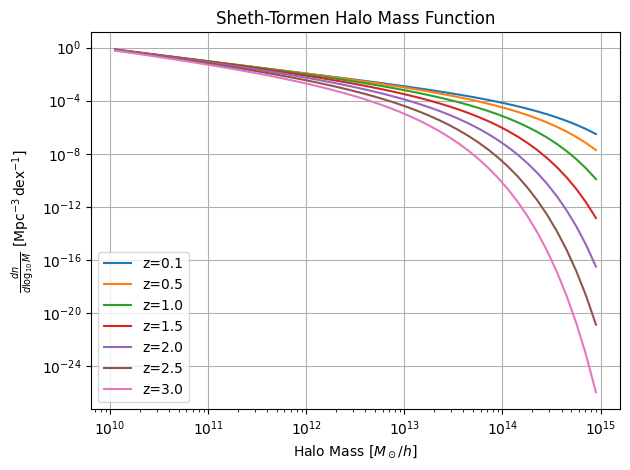

In [11]:
mass_centers = 0.5 * (mass_bins[:-1] + mass_bins[1:])
for i, z in enumerate(z_list):
    plt.plot(mass_centers, dn_dlogM_all[i], label=f"z={z}")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Halo Mass [$M_\odot/h$]")
plt.ylabel(r"$\frac{dn}{d\log_{10} M} \ [\mathrm{Mpc}^{-3} \, \mathrm{dex}^{-1}]$")
plt.title("Sheth-Tormen Halo Mass Function")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("ShethTormen_mass_function.png", dpi=300)
FileLink('ShethTormen_mass_function.png')

In [3]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import minimize_scalar
from scipy.interpolate import RegularGridInterpolator
from astropy.constants import G, c
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo
from math import pi

# ----------------------------------------
# (1) Cosmological parameters from Planck18
# ----------------------------------------
H0_si = cosmo.H0.to(u.s**-1).value           # H0 in 1/s
Omega_m = cosmo.Om0
Omega_lambda = cosmo.Ode0

# ----------------------------------------
# (2) Cosmological time delay
# ----------------------------------------
def cosmological_time_delay(z):
    def integrand(z_prime):
        E_z = np.sqrt(Omega_m * (1 + z_prime)**3 + Omega_lambda)
        return 1.0 / ((1 + z_prime) * E_z)
    result, _ = quad(integrand, 0, z)
    return result / H0_si  # in seconds

# ----------------------------------------
# (3) Load halo mass function interpolator (dn/dlog10M)
# ----------------------------------------
def load_nMz_interpolator(path):
    data = np.load(path)
    mass_bins = data['mass_bin_edges']  # linear M⊙
    z_vals = data['z_vals']
    dn_dlogM = data['dn_dlogM']         # shape (Nz, N_mass_bin)

    mass_centers = 0.5 * (mass_bins[:-1] + mass_bins[1:])
    logM = np.log10(mass_centers)

    # Force logM axis ascending
    sort_idx = np.argsort(logM)
    logM = logM[sort_idx]
    dn_dlogM = dn_dlogM[:, sort_idx]

    interpolator = RegularGridInterpolator((z_vals, logM), dn_dlogM)
    return interpolator

# ----------------------------------------
# (4) Virial radius from NFW profile
# ----------------------------------------
def r_vir(M_kg):
    # M in kg
    rho_c = 3 * H0_si**2 / (8 * pi * G.value)  # critical density in kg/m³
    delta_c = 200
    return (3 * M_kg / (4 * pi * delta_c * rho_c))**(1/3)  # in meters

# ----------------------------------------
# (5) Shapiro time delay (logM integral version)
# ----------------------------------------
def shapiro_time_delay(z, frequency, phi_target=None, M_max=1e15, optimize_mmin=True, interp_nMz=None):
    if isinstance(interp_nMz, str):
        interp_nMz = load_nMz_interpolator(interp_nMz)
    if interp_nMz is None:
        raise ValueError("interp_nMz must be provided.")

    logM_min, logM_max = interp_nMz.grid[1][0], interp_nMz.grid[1][-1]

    def integrand_logM(logM, z_):
        M_solar = 10**logM
        M_kg = M_solar * u.Msun.to(u.kg)
        Rvir = r_vir(M_kg)
        n = interp_nMz([[z_, logM]])[0]  # dn/dlog10M in Mpc^-3
        n_m3 = (n * u.Mpc**-3).to(u.m**-3).value

        result = (2 * G.value * M_kg) / (c.value**3 * Rvir) * n_m3

        return result


    def rms_objective(logM_min_cand):
        logM_min_cand = max(logM_min_cand, logM_min)
        result, _ = quad(integrand_logM, logM_min_cand, logM_max, args=(z,))
        delta_phi = 2 * pi * frequency * result
        return (delta_phi - phi_target)**2

    if optimize_mmin and phi_target is not None:
        opt = minimize_scalar(rms_objective, bounds=(logM_min, logM_max), method='bounded')
        logM_min_final = opt.x
    else:
        logM_min_final = max(np.log10(1e11), logM_min)

    result, _ = quad(integrand_logM, logM_min_final, logM_max, args=(z,), epsabs=1e-10)
    return result  # in seconds

# ----------------------------------------
# (6) Total phase shift Δφ
# ----------------------------------------
def total_phase_shift(frequency, z, phi_target=None, M_max=1e15, optimize_mmin=True, interp_nMz=None):
    dt_shapiro = shapiro_time_delay(z, frequency, phi_target, M_max, optimize_mmin, interp_nMz)
    dt_total = dt_shapiro
    delta_phi = 2 * pi * frequency * dt_total
    return delta_phi

# ----------------------------------------
# (7) Test function
# ----------------------------------------
def test_phase_shift():
    z = 0.3
    frequency = 10  # Hz
    interp = load_nMz_interpolator('ShethTormen_halo_mass_function.npz')

    delta_phi = total_phase_shift(
        frequency=frequency,
        z=z,
        phi_target=None,
        M_max=1e15,
        optimize_mmin=False,
        interp_nMz=interp
    )

    print(f"✅ z = {z}, f = {frequency} Hz")
    print(f"累计相位偏移 Δφ = {delta_phi} rad")

    if not np.isfinite(delta_phi):
        print("错误：结果为 NaN 或 Inf。")
    elif delta_phi < 0:
        print("警告：结果为负值。")
    elif delta_phi > 0.1:
        print("警告：相位偏移异常大，可能单位仍有问题。")
    else:
        print("数值合理，计算成功。")

In [4]:
test_phase_shift()

✅ z = 0.3, f = 10 Hz
累计相位偏移 Δφ = 8.470403644805751e-83 rad
数值合理，计算成功。


累积相位偏移（关于z和f）的可视化

波形修正

模板库构建

仿真数据生成

检测匹配滤波